# Goal of the NB
 - See how K Means efficiency improves on various levels of downsampled images
 - Compare that to speed changes in the DL approaches

# Imports

In [7]:
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore') #avoid annoying imshow deprecated
from typing import Literal
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
import warnings
import torch
from PIL import Image
from IPython.display import display
from transformers import pipeline
import time

import utils

# Load images

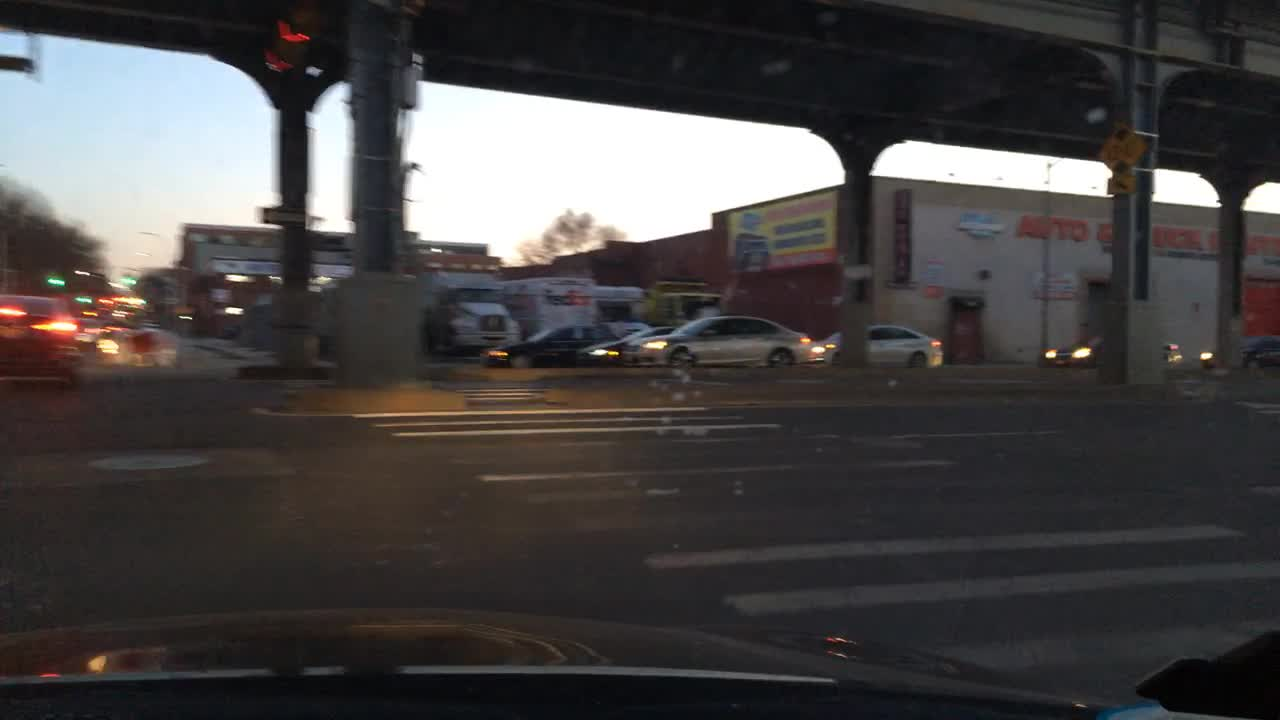

In [8]:
sample_img = Image.open('sample_images/f702ebe5-679718ad.jpg')
display(sample_img)

# K Means

100%|██████████| 50/50 [00:00<00:00, 94.72it/s]


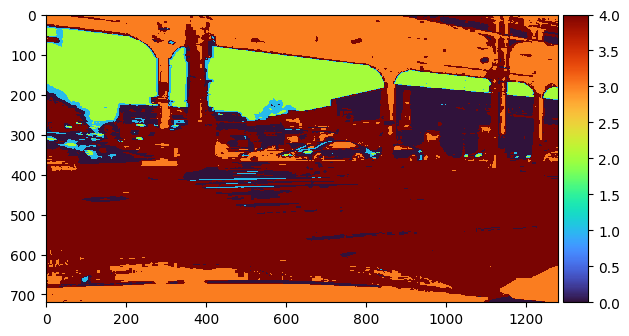

In [9]:
def segment_image_KMeans_torch(
    image: np.ndarray,
    k: int = 5,
    max_iter: int = 50,
    distance_fn: Literal['L2', 'L1', 'cos'] = 'L2',
    restarts: int = 1, #TODO: can implement if cluster quality poor
):
    image = np.array(image)
    device = torch.device('mps')
    img = torch.from_numpy(image).float().to(device)
    ROWS, COLS, CHANNELS = img.shape
    assert CHANNELS == 3

    flattened = img.reshape(-1, 3)
    N = flattened.shape[0]

    indices = torch.randint(0, N, (k,), device=device)
    centroids = flattened[indices]

    for _ in tqdm(range(max_iter)):
        old_centroids = centroids.clone()

        #assignment step (torch):
        px = flattened[:, None, :]
        cn = centroids[None, :, :]
        
        dists = utils.compute_distance(px, cn, distance_fn)
        labels = torch.argmin(dists, dim=1)

        #update step (torch):
        sums = torch.zeros((k, 3), device=device)
        counts = torch.zeros((k, 1), device=device)
        sums.index_add_(0, labels, flattened)
        counts.index_add_(0, labels, torch.ones((N, 1), device=device))

        active_mask = counts.squeeze() > 0
        centroids[active_mask] = sums[active_mask] / counts[active_mask]
        inactive_mask = ~active_mask

        if inactive_mask.any():
            num_dead = inactive_mask.sum()
            new_indices = torch.randint(0, N, (num_dead,), device=device)
            centroids[inactive_mask] = flattened[new_indices]

        if torch.allclose(centroids, old_centroids): break

    return labels.cpu().reshape(ROWS, COLS).numpy()

res = segment_image_KMeans_torch(image=sample_img, max_iter=50)

io.imshow(res, cmap='turbo') ; plt.show()

# Segformer

In [10]:
segmenter = pipeline("image-segmentation", model="nvidia/segformer-b0-finetuned-ade-512-512", device='mps', use_fast=True)

sample_img
outputs = segmenter(sample_img)

'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: d076d64e-e489-44e0-b313-f6e7540a24ce)')' thrown while requesting HEAD https://huggingface.co/nvidia/segformer-b0-finetuned-ade-512-512/resolve/main/config.json
Retrying in 1s [Retry 1/5].
Device set to use mps


(1280, 720)


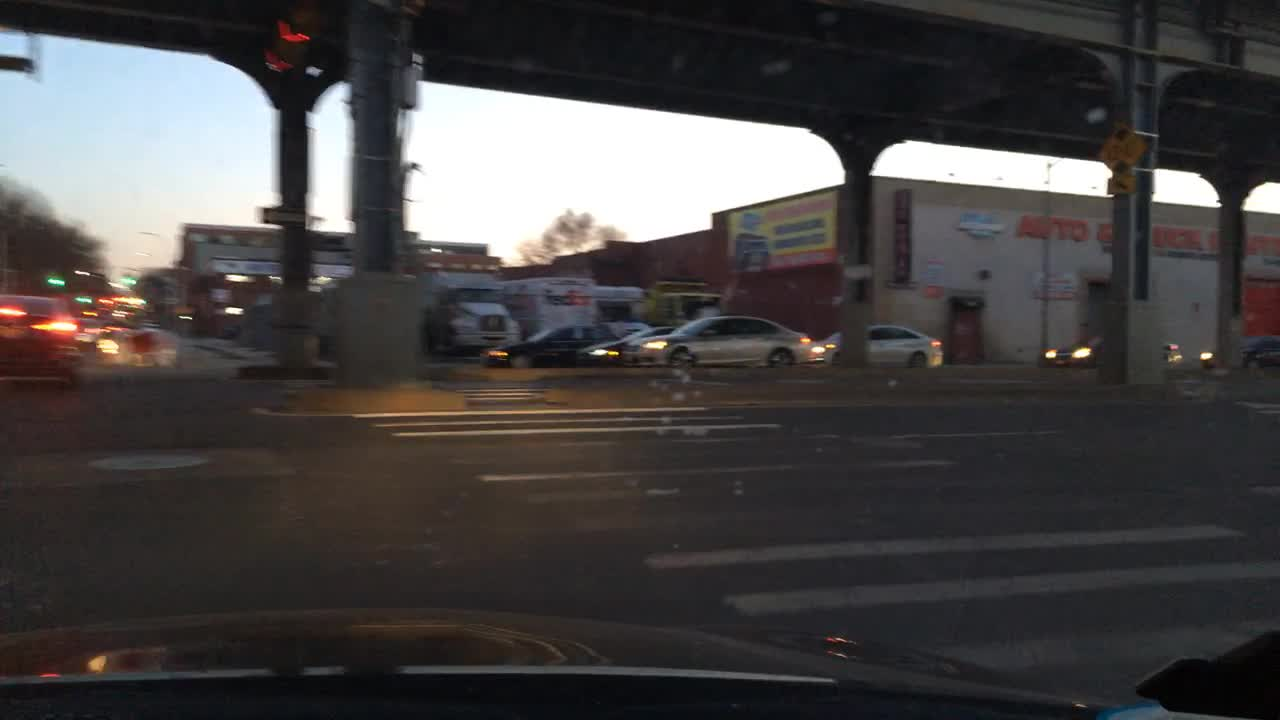

(640, 360)


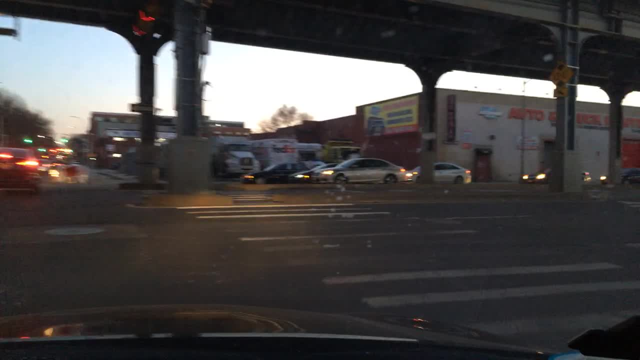

(426, 240)


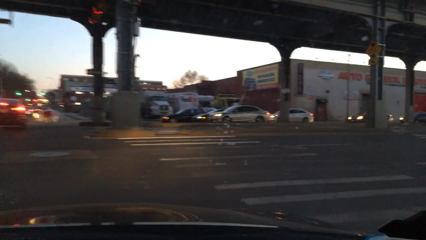

(320, 180)


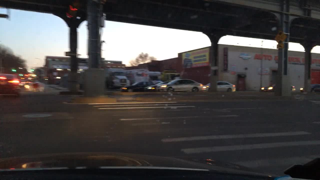

(256, 144)


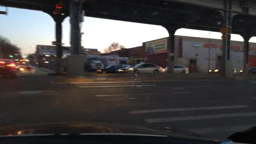

(213, 120)


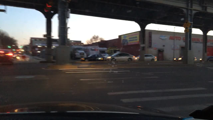

(182, 102)


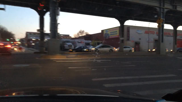

(160, 90)


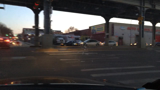

In [11]:
H, W = sample_img.size
pyramid = [img.resize((int(H/(i+1)), int(W/(i+1)))) for i, img in enumerate([sample_img]*8)]

for img in pyramid:
    print(img.size)
    display(img)

 50%|█████     | 10/20 [00:00<00:00, 201.57it/s]


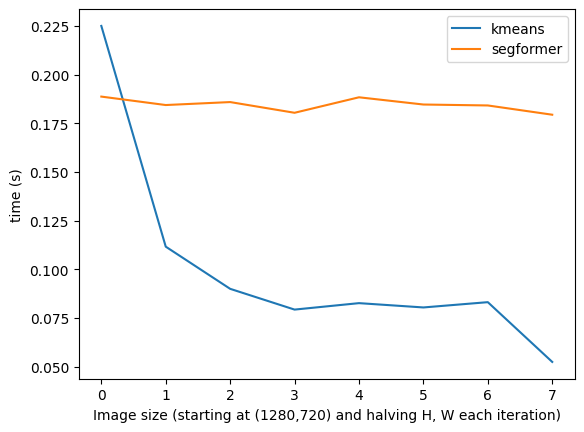

In [12]:
times_kmeans = []
times_segformer = []

for img in pyramid:
    time_s = time.time()
    segment_image_KMeans_torch(img, max_iter=20)
    times_kmeans.append(time.time() - time_s)

    time_s = time.time()
    segmenter(sample_img)
    times_segformer.append(time.time() - time_s)

plt.plot(times_kmeans, label='kmeans')
plt.plot(times_segformer, label='segformer')
plt.ylabel('time (s)') ; plt.xlabel('Image size (starting at (1280,720) and halving H, W each iteration)')
plt.legend() ; plt.show()